# Music genre identification:
## XGBoost based genre classifier
### John Burt
#### August 2019


In this notebook, I train an XGBoost classifier to classify song genre using pre-generated audio features. 


#### Methods:

Most of the features I chose are based on Harmonic-percussive source separation, and MFCC:

- Zero crossing rate
- Mean harmonic frequency amplitudes over the duration of the sound clip
- Mean and max percussive tempo frequency amplitudes over the duration of the sound clip
- mean MFCC frequency amplitude over the duration of the sound clip

These features are generated in another notebook and saved as a csv file for this notebook to load.

#### Extra packages required:
- librosa
- xgboost


####  Source data:

The feature data is generated from music clips:

- The original data is from ["FMA: A Dataset For Music Analysis"](https://github.com/mdeff/fma). That dataset is a dump of sound clips and associated metadata from the Free Music Archive (FMA), an interactive library of high-quality, legal audio downloads. 


- For the meetup series, the music sampled were reduced further to a "warmup set" of 4000 samples of folk and 4000 samples of hip-hop musi (making this a binary classification problem). This code uses the warmup set, but it can also use the original music clip dataset, which is much larger and has more genre categories.




In [1]:
# remove warnings
import warnings
warnings.filterwarnings('ignore')
# ---

%matplotlib inline
from matplotlib import pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')

import pandas as pd
pd.options.display.max_columns = 100

import numpy as np

#  high and low resolution feature datasets
# (previously generated by another notebook/script)
feature_rez = 'hi'
featuredatafile = 'features_'+feature_rez+'rez.csv'

# data source directory
srcdir = './warmup/' # PDSG 'warmup' dataset (200 samples)
# metadatafile = 'pdsg_musicgenre_warmup_small.csv'

# srcdir = './fma_small/' # small version of original dataset (8000 samples)
# metadatafile = 'raw_tracks.csv'

# read the feature data file
df = pd.read_csv(srcdir+featuredatafile)

print('Read feature data - df.shape:',df.shape)


Read feature data - df.shape: (200, 1156)


## Prep training data

In [8]:
from sklearn.model_selection import train_test_split

# change label column to categorical
df['genre'] = pd.Categorical(df['genre'])

# for the test prediction, I just train with all labelled data
X = df.iloc[:,2:].values
X_colnames = df.iloc[:,2:].columns

# convert string genre categories to numbers
y = df['genre'].cat.codes.values
y_labels = df['genre']

print('X_train.shape:',X.shape)


X_train.shape: (200, 1154)


## Train and cross-validation test classifier

Cross-validation reveals 89% mean accuracy, which isn't too bad. 

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

# create model instance
clf = XGBClassifier()

# get cross val score
scores = cross_val_score(clf, X, y, cv=3, scoring='balanced_accuracy')

print('Cross-validate model, metric = balanced accuracy:')
print('CV scores = ', ['%1.2f,'%(s) for s in scores])
print('mean score = %1.2f'%(np.mean(scores)))

# re-fit to entire dataset
clf.fit(X, y);


Cross-validate model, metric = balanced accuracy:
CV scores =  ['0.90,', '0.92,', '0.86,']
mean score = 0.89


# Results looking at the 20 most important features:

- It appears that harmonic frequency means in the lower frequency range are the most common important features (13).

- Tempogram means in the higher frequency range are the second most common important feature (6)

- Only one MFCC frequency feature was in the top 20.

This suggests that the harmonic and tempogram features were sufficient for the classifier to perform well. In the future, I will try eliminating the MFC and zero-crossing rate features to see if that improves (or doesn't degrade) performance. 

Another area that I will explore is how these features perform with more than just two genres, and using different classifiers.

Feature ranking:
1. (0.122) hf_mean_3
2. (0.051) tf_max_290
3. (0.046) tf_max_262
4. (0.042) hf_mean_86
5. (0.026) tf_max_226
6. (0.024) hf_mean_4
7. (0.022) hf_mean_57
8. (0.022) hf_mean_19
9. (0.021) hf_mean_16
10. (0.019) hf_mean_42
11. (0.018) tf_med_53
12. (0.018) tf_max_71
13. (0.017) mfc_mean_7
14. (0.017) hf_mean_43
15. (0.015) hf_mean_84
16. (0.015) tf_max_38
17. (0.014) hf_mean_17
18. (0.013) hf_mean_2
19. (0.013) hf_mean_52
20. (0.012) hf_mean_200


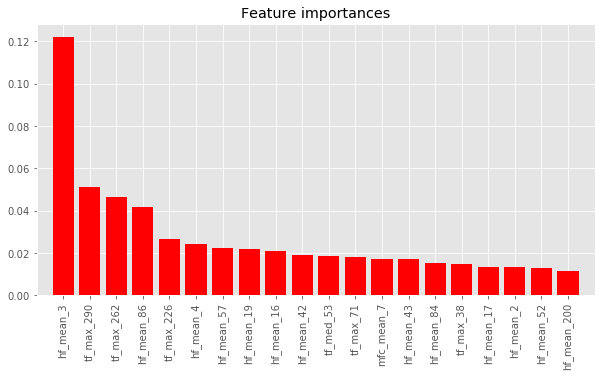

In [11]:
names = X_colnames
numimportant = 20

importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(numimportant):
    print("%d. (%1.3f) %s" % (
        f + 1, 
        importances[indices[f]],
        names[indices[f]], 
         ))

# Plot the feature importances of the forest
plt.figure(figsize=[10,5])
plt.title("Feature importances")
plt.bar(range(numimportant), importances[indices[:numimportant]],
       color="r", align="center")
plt.xticks(range(numimportant), names[indices[:numimportant]], rotation=90)
plt.xlim([-1, numimportant]);

# Predict genre of holdout test data

For the meetup, we provided a holdout set for participants to test their models against. My model scored 88% accuracy.


### Function to generate features from audio clip

In [4]:
import librosa
import librosa.display
from sklearn.preprocessing import minmax_scale

def moving_mean(x, windowsize):
    """Split each row of x into bins of windowsize length 
       and return an array of the bin means"""
    a = list(x)
    if len(a)%windowsize == 0: extra=0 
    else: extra=windowsize-(len(a)%windowsize)
    a.extend([np.nan]*extra)
    return np.mean(np.array(a).reshape(( int(len(a)/windowsize), windowsize )),axis=1)

def generate_features(y, sr, feat_rez='hi', fftsize=512, hop_length = 50, 
                      margin=16, nmfcc = 2000, windowsize = 5):
    """Generate features from wave data, same as with the training data"""
    
    zero_cross_rate = np.sum(librosa.zero_crossings(y))/len(y)

    D = librosa.stft(y, hop_length=hop_length, n_fft=fftsize)
    D_harmonic, D_percussive = librosa.decompose.hpss(D, margin=margin)

    harmonic_freqs_mean = minmax_scale(np.mean(np.abs(D_harmonic), axis=1))

    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram = np.abs(librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                   hop_length=hop_length))
    tempo_adj = (tempogram.T - np.mean(tempogram, axis=1).T).T  
    tempo_freqs_max =  minmax_scale(np.max(tempo_adj, axis=1))
    tempo_freqs_med =  minmax_scale(np.median(tempo_adj, axis=1))

    mfc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=nmfcc, n_fft=fftsize)
    mfc_mean = minmax_scale(np.mean(mfc,axis=1))

    harmonic_freqs_mean_r = moving_mean(harmonic_freqs_mean, windowsize)
    tempo_freqs_max_r = moving_mean(tempo_freqs_max, windowsize*2)
    tempo_freqs_med_r = moving_mean(tempo_freqs_med, windowsize*2)
    mfc_mean_r = moving_mean(mfc_mean, windowsize)
    
    if feat_rez == 'hi':
        # combine all features into one list
        return   ([zero_cross_rate] + 
                    list(harmonic_freqs_mean) +
                    list(tempo_freqs_max) +
                    list(tempo_freqs_med) +
                    list(mfc_mean) 
                   )
    else:
        return   ([zero_cross_rate] + 
                    list(harmonic_freqs_mean_r) +
                    list(tempo_freqs_max_r) +
                    list(tempo_freqs_med_r) +
                    list(mfc_mean_r) 
                   )


### Load audio clips and generate features for classification

In [6]:
import os
import fnmatch

# parameters used in training set for feature generation
fftsize=512
hop_length = 50
margin=16
nmfcc = 2000
windowsize = 5

# load test data
testdir = './warmup_test/'

# keep a lit of filenames
clipfilenames = []

# search through source folder for sound files
# NOTE: this code assumes all clips in root of testdir
for root, dirnames, filenames in os.walk(testdir):
    numclips = len(fnmatch.filter(filenames, '*.wav'))
    for filename, i in zip(fnmatch.filter(filenames, '*.wav'), range(numclips)):

        y, sr = librosa.load(os.path.join(root, filename), sr=None)

        features = generate_features(y, sr, feat_rez=feature_rez, fftsize=fftsize, hop_length=hop_length, 
                      margin=margin, nmfcc=nmfcc, windowsize=windowsize)

        # on first iteration, create the array to hold the feature data
        if i == 0:
            feature_arr = np.array(np.zeros([numclips,len(features)]))

        feature_arr[i,:] = features
        clipfilenames.append(filename)

print('X.shape',X.shape)
print('test data shape',feature_arr.shape)


X.shape (200, 1154)
test data shape (50, 1154)


## Predict genres from features and save to file for submission

In [ ]:
y_out = clf.predict(feature_arr)

y_pred = (np.where(y_out>.5,1,0))

pred_df = pd.DataFrame({'filename':clipfilenames, 
                         'genre':np.where(y_pred==0,'Folk','Hip-Hop')})

pred_df.to_csv(testdir+'test_predictions.csv', index=False)
